### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2005GB002530

Regions considered for this study based on Mikaloff Fletcher et al. (2003). NAH denotes North Atlantic high latitudes, NAM denotes North Atlantic midlatitudes, NAL denotes North Atlantic low latitudes, and NAT denotes North Atlantic tropics. The southern boundaries for the regions are at 0.08 latitude (NAT region), 17.7818N (NAL region), 35.5638N (NAM region), and 48.9018N (NAH region). The northern boundary of the NAH region is at 75.5958N. The North Atlantic region is defined as the combination of all four regions.

In [4]:
extract = False

if extract:

    tgrid = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')

    array = tgrid['tmask'][0,0,:,:]

    NAT = np.zeros_like(tgrid['tmask'][:].values)
    NAL = np.zeros_like(tgrid['tmask'][:].values)
    NAM = np.zeros_like(tgrid['tmask'][:].values)
    NAH = np.zeros_like(tgrid['tmask'][:].values)

    tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')
    ATL = np.array(tmask['ATL'])

    nav_lon = tgrid['nav_lon'].values
    nav_lat = tgrid['nav_lat'].values

    for d in range(0,31):

        NAT[:,d,:,:] = ATL
        NAL[:,d,:,:] = ATL
        NAM[:,d,:,:] = ATL

    NAT[:,:,0:73,:] = 0
    NAT[:,:,90:150,:] = 0
    NAL[:,:,0:90,:] = 0
    NAL[:,:,100:150,:] = 0
    NAM[:,:,0:100,:] = 0
    NAM[:,:,109:150,:] = 0

    NAH = np.copy(tgrid.tmask.values)
    NAH[:,:,0:109,:] = 0
    NAH[:,:,:,0:111] = 0
    NAH[:,:,139:150,:] = 0
    NAH[:,:,:,155:190] = 0
    NAH[:,:,110:130,145:160] = 0 # fuck the baltic
    
    land = np.where(tgrid.tmask.values == 0)
    NAT[land] = 0
    NAL[land] = 0
    NAM[land] = 0

    tgrid['NAT'] = tgrid['tmask'].copy()
    tgrid['NAT'].data = NAT
    tgrid['NAL'] = tgrid['tmask'].copy()
    tgrid['NAL'].data = NAL
    tgrid['NAM'] = tgrid['tmask'].copy()
    tgrid['NAM'].data = NAM
    tgrid['NAH'] = tgrid['tmask'].copy()
    tgrid['NAH'].data = NAH

    
    ATL = np.zeros_like(tgrid['tmask'][:].values)
    ATL[np.where(NAT == 1)] = 1
    ATL[np.where(NAL == 1)] = 1
    ATL[np.where(NAM == 1)] = 1
    ATL[np.where(NAH == 1)] = 1
    tgrid['ATL'] = tgrid['tmask'].copy()
    tgrid['ATL'].data = ATL
    
    tgrid.to_netcdf('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/meshmask_with_Atl.nc')
    
    year = 1984; model = 'RVA0'; typ = 'ptrc'
    tdi = '/gpfs/data/greenocean/software/runs/TOM12_TJ_'

    tfi = xr.open_dataset(f'{tdi}{model}/ORCA2_1m_{year}0101_{year}1231_{typ}_T.nc')

    tfi = tfi.drop_vars([
        "Alkalini","O2", "DIC", "PIIC", "NO3", "Si", "PO4", "Fer", "DOC", "CaCO3", "ARA", 
        "POC", "GOC", "BAC", "PRO", "PTE", "MES", "GEL", "MAC", "DIA", "MIX", 
        "COC", "PIC", "PHA", "FIX", "BSi",
    ])


    atl = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/meshmask_with_Atl.nc')

    cvol = np.zeros([1,31,149,182])

    for i in range(0,31):
        cvol[0,i,:,:] = atl.tmask[0,i,:,:] * atl.e1t[0,:,:] * atl.e2t[0,:,:] * atl.e3t_0[0,i,:,:]


    ATL = (atl.ATL[:,:,:,:].values)
    NAT = (atl.NAT[:,:,:,:].values)
    NAL = (atl.NAL[:,:,:,:].values)
    NAM = (atl.NAM[:,:,:,:].values)
    NAH = (atl.NAH[:,:,:,:].values)

    ATLb = np.zeros([12,31,149,182])
    NATb = np.zeros([12,31,149,182])
    NALb = np.zeros([12,31,149,182])
    NAMb = np.zeros([12,31,149,182])
    NAHb = np.zeros([12,31,149,182])
    cvolb = np.zeros([12,31,149,182])

    for i in range (0,12):
        ATLb[i,:,:,:] = ATL
        NATb[i,:,:,:] = NAT
        NALb[i,:,:,:] = NAL
        NAMb[i,:,:,:] = NAM
        NAHb[i,:,:,:] = NAH
        cvolb[i,:,:,:] = cvol

    tfi['ATL'] = tfi.GON.copy()
    tfi['ATL'].data = ATLb

    tfi['NAT'] = tfi.GON.copy()
    tfi['NAT'].data = NATb

    # For NAL
    tfi['NAL'] = tfi.GON.copy()
    tfi['NAL'].data = NALb

    # For NAM
    tfi['NAM'] = tfi.GON.copy()
    tfi['NAM'].data = NAMb

    # For NAH
    tfi['NAH'] = tfi.GON.copy()
    tfi['NAH'].data = NAHb

    # For NAH
    tfi['cvol'] = tfi.GON.copy()
    tfi['cvol'].data = cvolb

    tfi.drop_vars(['GON'])

    tfi.to_netcdf('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/meshmask_with_Atl_broad.nc')

## plot the nice meshmask

Text(-45, 55, 'NAH')

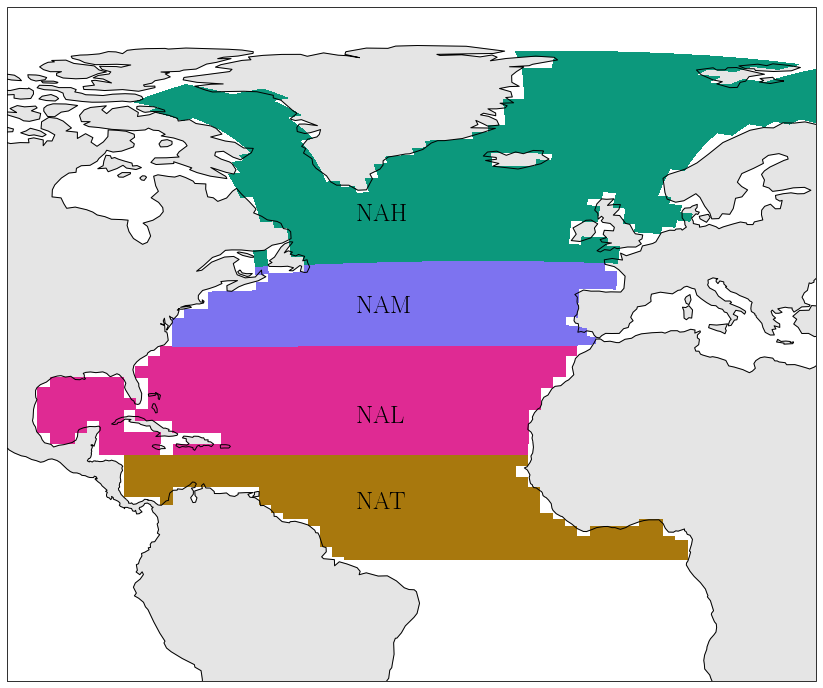

In [5]:
atl = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/meshmask_with_Atl.nc')

    
regs = ['NAT', 'NAL', 'NAM', 'NAH']#, 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'NAT' : {'number' : 1},
           'NAL' : {'number': 2},
          'NAM' : {'number': 3},
           'NAH' : {'number': 4},
           
          }

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[atl[regs[i]][0,0,:,:] == 1] = regdict[regs[i]]['number']
maskno[maskno == 0] = np.nan

fact = 1
tfig = plt.figure(figsize=[14.5*fact, 14.5*fact])
ax = plt.axes(projection=ccrs.PlateCarree())

year = 1984
tgrid = xr.open_dataset(f'/gpfs/data/greenocean/software/runs/TOM12_TJ_RVA0/ORCA2_1m_{year}0101_{year}1231_ptrc_T.nc')

nav_lon = tgrid['nav_lon'].values
nav_lat = tgrid['nav_lat'].values
mesh = ax.pcolormesh(nav_lon, nav_lat, maskno, transform=ccrs.PlateCarree(), cmap=cm.phase, zorder =0, alpha = 1,\
                    vmin = 1, vmax = 5)

ax.coastlines(zorder = 1 )
#lons, lats extent
ax.set_extent([ -102, 30, -20, 120,], crs=ccrs.PlateCarree())

ax.add_feature(cp.feature.LAND, color='grey', alpha = 0.2)

ax.text(-45, 8, s = f'NAT', color='k', \
        fontsize = 25, fontweight = 'bold', transform=ccrs.Geodetic())
ax.text(-45, 22, s = f'NAL', color='k', \
        fontsize = 25, fontweight = 'bold', transform=ccrs.Geodetic())
ax.text(-45, 40, s = f'NAM', color='k', \
        fontsize = 25, fontweight = 'bold', transform=ccrs.Geodetic())
ax.text(-45, 55, s = f'NAH', color='k', \
        fontsize = 25, fontweight = 'bold', transform=ccrs.Geodetic())

## timeseries made in
    
    'made in':'/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/extract/natl_bio.py',
    'made in':'/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/extract/natl_diad.py',

In [6]:
def make_yearlist(yrst, yrend, dtype, mod = 'RVA0'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/{mod}_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

ptrc = xr.open_mfdataset(make_yearlist(1950,2020,'ptrc'))
diad = xr.open_mfdataset(make_yearlist(1950,2020,'diad'))

ptrcD = xr.open_mfdataset(make_yearlist(1950,2020,'ptrc', 'RVD0'))
diadD = xr.open_mfdataset(make_yearlist(1950,2020,'diad', 'RVD0'))
## open diad and ptrc ts

# "DIA", "MIX", "COC", "PIC", "PHA", "FIX",
## plot surface 100m DIC, NO3, Si, Fer, Phy, Diatom proportion 

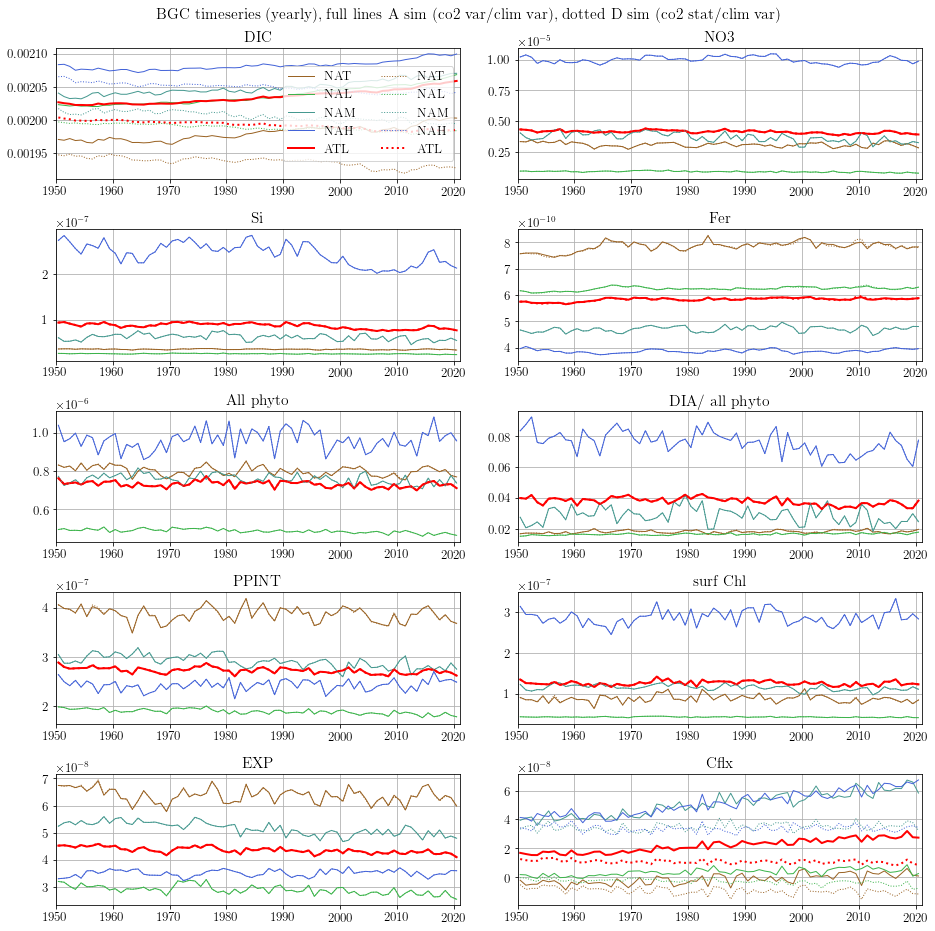

In [7]:
regdict = {'NAT' : {'color' : '#9A6324'},
           'NAL' : {'color': '#3cb44b'},
          'NAM' : {'color': '#469990'},
           'NAH' : {'color': '#4363d8'},
           'ATL' : {'color': 'r'},
           
          }

regs = ['NAT', 'NAL', 'NAM', 'NAH', 'ATL']
lws = [1,1,1,1,2]


#DIC, NO3, Si, Fer, Phy, Diat
fact = 1.1
fig, axs = plt.subplots(5,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for r in range(0,5):
    reg = regs[r]; lw = lws[r]; col = regdict[reg]['color']
    
    DIC = ptrc.sel(var = 'DIC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    axs[0].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linewidth = lw, color = col, label = reg)
    
    DIC = ptrc.sel(var = 'NO3').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    axs[1].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linewidth = lw, color = col)
    
    DIC = ptrc.sel(var = 'Si').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    axs[2].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linewidth = lw, color = col)
    
    DIC = ptrc.sel(var = 'Fer').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    axs[3].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linewidth = lw, color = col)
    
    ## "DIA", "MIX", "COC", "PIC", "PHA", "FIX",
    DIA = ptrc.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    MIX = ptrc.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    COC = ptrc.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    PIC = ptrc.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    PHA = ptrc.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    FIX = ptrc.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    PHY = DIA + MIX + COC + PIC + PHA + FIX
    DIAPRO = DIA/PHY
    axs[4].plot(PHY.time_counter.groupby('time_counter.year').mean(), \
             PHY.regmean.groupby('time_counter.year').mean(), linewidth = lw, color = col)
    
    axs[5].plot(DIAPRO.time_counter.groupby('time_counter.year').mean(), \
             DIAPRO.regmean.groupby('time_counter.year').mean(), linewidth = lw, color = col)
    
    ##PPINT, TChl, EXP, Cflx
    DIC = diad.sel(varf = 'PPINT').sel(prov = reg)
    axs[6].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmeanf.groupby('time_counter.year').mean(), linewidth = lw, color = col)

    DIC = diad.sel(var = 'TChl').isel(deptht = 0).sel(prov = reg)
    axs[7].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linewidth = lw, color = col)
    
    DIC = diad.sel(var = 'EXP').isel(deptht = 9).sel(prov = reg)
    axs[8].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linewidth = lw, color = col)

    DIC = diad.sel(varf = 'Cflx').sel(prov = reg)
    axs[9].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmeanf.groupby('time_counter.year').mean(), linewidth = lw, color = col)
    
    
for r in range(0,5):
    reg = regs[r]; lw = lws[r]; col = regdict[reg]['color']
    
    DIC = ptrcD.sel(var = 'DIC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    axs[0].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col, label = reg)
    
    DIC = ptrcD.sel(var = 'NO3').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    axs[1].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)
    
    DIC = ptrcD.sel(var = 'Si').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    axs[2].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)
    
    DIC = ptrcD.sel(var = 'Fer').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    axs[3].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)
    
    ## "DIA", "MIX", "COC", "PIC", "PHA", "FIX",
    DIA = ptrcD.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    MIX = ptrcD.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    COC = ptrcD.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    PIC = ptrcD.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    PHA = ptrcD.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    FIX = ptrcD.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    PHY = DIA + MIX + COC + PIC + PHA + FIX
    DIAPRO = DIA/PHY
    axs[4].plot(PHY.time_counter.groupby('time_counter.year').mean(), \
             PHY.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)
    
    axs[5].plot(DIAPRO.time_counter.groupby('time_counter.year').mean(), \
             DIAPRO.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)
    
    ##PPINT, TChl, EXP, Cflx
    DIC = diadD.sel(varf = 'PPINT').sel(prov = reg)
    axs[6].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmeanf.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)

    DIC = diadD.sel(var = 'TChl').isel(deptht = 0).sel(prov = reg)
    axs[7].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)
    
    DIC = diadD.sel(var = 'EXP').isel(deptht = 9).sel(prov = reg)
    axs[8].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)

    DIC = diadD.sel(varf = 'Cflx').sel(prov = reg)
    axs[9].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmeanf.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)
    
tits = ['DIC', 'NO3', 'Si', 'Fer', 'All phyto', 'DIA/ all phyto','PPINT','surf Chl','EXP','Cflx']

    
tits = ['DIC', 'NO3', 'Si', 'Fer', 'All phyto', 'DIA/ all phyto','PPINT','surf Chl','EXP','Cflx']


for i in range(0,10):
    axs[i].set_title(tits[i])
    start_date = pd.to_datetime('1950-01-01')
    end_date = pd.to_datetime('2020-12-31')
    axs[i].set_xlim([start_date, end_date])
    axs[i].grid()
    axs[0].legend(ncol = 2, loc = 'best')

plt.suptitle('BGC timeseries (yearly), full lines A sim (co2 var/clim var), dotted D sim (co2 stat/clim var)')
plt.tight_layout()

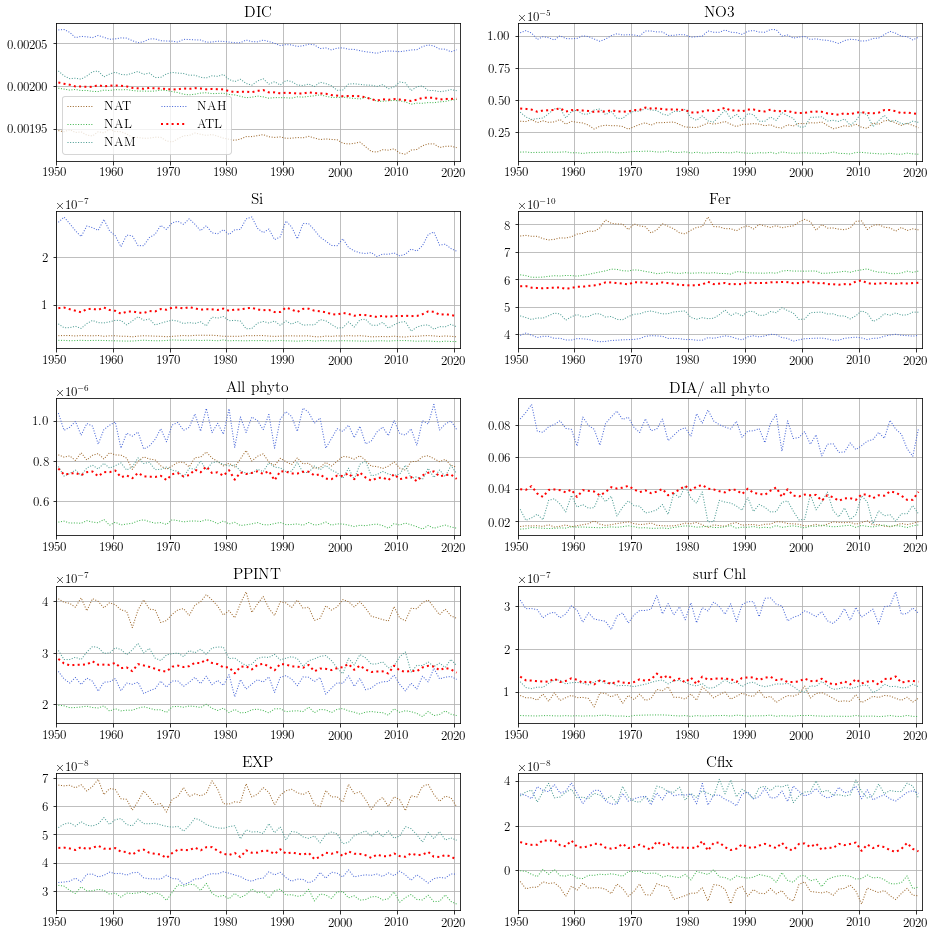

In [8]:
regdict = {'NAT' : {'color' : '#9A6324'},
           'NAL' : {'color': '#3cb44b'},
          'NAM' : {'color': '#469990'},
           'NAH' : {'color': '#4363d8'},
           'ATL' : {'color': 'r'},
           
          }

regs = ['NAT', 'NAL', 'NAM', 'NAH', 'ATL']
lws = [1,1,1,1,2]


#DIC, NO3, Si, Fer, Phy, Diat
fact = 1.1
fig, axs = plt.subplots(5,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for r in range(0,5):
    reg = regs[r]; lw = lws[r]; col = regdict[reg]['color']
    
    DIC = ptrcD.sel(var = 'DIC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    axs[0].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col, label = reg)
    
    DIC = ptrcD.sel(var = 'NO3').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    axs[1].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)
    
    DIC = ptrcD.sel(var = 'Si').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    axs[2].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)
    
    DIC = ptrcD.sel(var = 'Fer').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    axs[3].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)
    
    ## "DIA", "MIX", "COC", "PIC", "PHA", "FIX",
    DIA = ptrcD.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    MIX = ptrcD.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    COC = ptrcD.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    PIC = ptrcD.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    PHA = ptrcD.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    FIX = ptrcD.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
    PHY = DIA + MIX + COC + PIC + PHA + FIX
    DIAPRO = DIA/PHY
    axs[4].plot(PHY.time_counter.groupby('time_counter.year').mean(), \
             PHY.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)
    
    axs[5].plot(DIAPRO.time_counter.groupby('time_counter.year').mean(), \
             DIAPRO.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)
    
    ##PPINT, TChl, EXP, Cflx
    DIC = diadD.sel(varf = 'PPINT').sel(prov = reg)
    axs[6].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmeanf.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)

    DIC = diadD.sel(var = 'TChl').isel(deptht = 0).sel(prov = reg)
    axs[7].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)
    
    DIC = diadD.sel(var = 'EXP').isel(deptht = 9).sel(prov = reg)
    axs[8].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmean.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)

    DIC = diadD.sel(varf = 'Cflx').sel(prov = reg)
    axs[9].plot(DIC.time_counter.groupby('time_counter.year').mean(), \
             DIC.regmeanf.groupby('time_counter.year').mean(), linestyle = ':', linewidth = lw, color = col)
    
tits = ['DIC', 'NO3', 'Si', 'Fer', 'All phyto', 'DIA/ all phyto','PPINT','surf Chl','EXP','Cflx']


for i in range(0,10):
    axs[i].set_title(tits[i])
    start_date = pd.to_datetime('1950-01-01')
    end_date = pd.to_datetime('2020-12-31')
    axs[i].set_xlim([start_date, end_date])
    axs[i].grid()
    axs[0].legend(ncol = 2, loc = 'best')
    
plt.tight_layout()

In [9]:
from scipy.stats import pearsonr
## 
RVA0_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_RVA0_1945-2022.nc')
amoc = RVA0_amoc.AMOC.sel(TIME=slice(f'{1950}-01-01', f'{2020}-12-31'))
tdat = amoc
# Define the range of depths and latitudes
regs = ['ATL','NAH','NAM','NAL','NAT']
rows = ['NO3', 'Si', 'Fer', 'PHY', 'DIA-prop','PPINT','surf-Chl','EXP', 'Cflx']

# Initialize a DataFrame to hold the correlation coefficients
correlation_table = pd.DataFrame(index=regs, columns=rows)

# # Populate the table with correlation coefficients
for L in range(0,len(rows)):
    Li = (rows[L])
    print(Li)
        
    for d in range(0,len(regs)):
        reg = regs[d]
        
        if Li == 'NO3':
            tdat = ptrc.regmean.sel(var = 'NO3').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
        if Li == 'Si':
            tdat = ptrc.regmean.sel(var = 'Si').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
        if Li == 'Fer':
            tdat = ptrc.regmean.sel(var = 'Fer').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
        if Li == 'PHY':
            DIA = ptrc.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            MIX = ptrc.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            COC = ptrc.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            PIC = ptrc.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            PHA = ptrc.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            FIX = ptrc.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            tdat = DIA + MIX + COC + PIC + PHA + FIX
        if Li == 'DIA-prop':
            DIA = ptrc.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            MIX = ptrc.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            COC = ptrc.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            PIC = ptrc.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            PHA = ptrc.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            FIX = ptrc.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            tdat = DIA/(DIA + MIX + COC + PIC + PHA + FIX)    
        if Li == 'PPINT':

            tdat = diad.regmeanf.sel(varf = 'PPINT').sel(prov = reg)
            
        if Li == 'surf-Chl':
            
            tdat = diad.regmean.sel(var = 'TChl').isel(deptht = 0).sel(prov = reg)
            
        if Li == 'EXP':
            
            tdat = diad.regmean.sel(var = 'EXP').isel(deptht = 9).sel(prov = reg)
            

#     print(L)
#     row60 = xr.open_mfdataset(make_yearlist(1950, 2021, 'NO3', 'RVA0', bd = L))

#     for d in depths:
#         row60_h = row60.water_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#         .sel(depthlevel = d).sel(type = 'pos')
#         variable = row60_h.values
        correlation_coefficient, _ = pearsonr(amoc, tdat)
        correlation_table.at[reg, Li] = correlation_coefficient

correlation_table = correlation_table.apply(pd.to_numeric, errors='coerce')



NO3
Si
Fer
PHY
DIA-prop
PPINT
surf-Chl
EXP
Cflx


In [10]:
correlation_table

,NO3,Si,Fer,PHY,DIA-prop,PPINT,surf-Chl,EXP,Cflx
ATL,0.103192,-0.308927,-0.108685,0.630698,0.111296,0.723065,0.355743,0.740384,0.266365
NAH,-0.051508,-0.442918,-0.342933,0.523324,0.116386,0.704202,0.305822,0.763124,0.266365
NAM,0.162874,0.652642,0.288720,0.786978,-0.478760,0.740925,0.189185,0.696259,0.266365
NAL,0.105858,0.505102,-0.506470,0.750524,-0.365898,0.680276,-0.143355,0.485691,0.266365
NAT,0.334129,0.561482,0.231865,0.230804,0.333524,0.262429,0.195874,0.266365,0.266365


In [11]:
from scipy.stats import pearsonr
## 
RVA0_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_RVA0_1945-2022.nc')
amoc = RVA0_amoc.AMOC.sel(TIME=slice(f'{1950}-01-01', f'{2020}-12-31'))
tdat = amoc
# Define the range of depths and latitudes
regs = ['ATL','NAH','NAM','NAL','NAT']
rows = ['NO3', 'Si', 'Fer', 'PHY', 'DIA-prop','PPINT','surf-Chl','EXP', 'Cflx']

# Initialize a DataFrame to hold the correlation coefficients
correlation_table = pd.DataFrame(index=regs, columns=rows)

# # Populate the table with correlation coefficients
for L in range(0,len(rows)):
    Li = (rows[L])
    print(Li)
        
    for d in range(0,len(regs)):
        reg = regs[d]
        
        if Li == 'NO3':
            tdat = ptrcD.regmean.sel(var = 'NO3').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
        if Li == 'Si':
            tdat = ptrcD.regmean.sel(var = 'Si').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
        if Li == 'Fer':
            tdat = ptrcD.regmean.sel(var = 'Fer').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
        if Li == 'PHY':
            DIA = ptrcD.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            MIX = ptrcD.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            COC = ptrcD.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            PIC = ptrcD.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            PHA = ptrcD.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            FIX = ptrcD.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            tdat = DIA + MIX + COC + PIC + PHA + FIX
        if Li == 'DIA-prop':
            DIA = ptrcD.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            MIX = ptrcD.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            COC = ptrcD.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            PIC = ptrcD.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            PHA = ptrcD.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            FIX = ptrcD.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht')
            tdat = DIA/(DIA + MIX + COC + PIC + PHA + FIX)    
        if Li == 'PPINT':

            tdat = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = reg)
            
        if Li == 'Cflx':

            tdat = diadD.regmeanf.sel(varf = 'Cflx').sel(prov = reg)
            
        if Li == 'surf-Chl':
            
            tdat = diadD.regmean.sel(var = 'TChl').isel(deptht = 0).sel(prov = reg)
            
        if Li == 'EXP':
            
            tdat = diadD.regmean.sel(var = 'EXP').isel(deptht = 9).sel(prov = reg)

        correlation_coefficient, p = pearsonr(amoc, tdat)
        print(f'{reg} {correlation_coefficient}, {p}')
        if p > 0.05:
            correlation_coefficient = 0
        correlation_table.at[reg, Li] = correlation_coefficient

correlation_table_m = correlation_table.apply(pd.to_numeric, errors='coerce')



NO3
ATL 0.10326040543084504, 0.0025468647484153915
NAH -0.05164341680270615, 0.13201230134095263
NAM 0.1629034025316829, 1.7531510921948335e-06
NAL 0.10614783621514419, 0.0019184572783295802
NAT 0.3345907154464747, 9.870552129058086e-24
Si
ATL -0.30873863167025867, 2.839653139527294e-20
NAH -0.4429276538306453, 3.0204571228943383e-42
NAM 0.6525337864990061, 1.673246906682175e-104
NAL 0.5052838516392473, 2.095323612041982e-56
NAT 0.5646052767517431, 6.786641998172571e-73
Fer
ATL -0.11386651312971097, 0.0008696792543847709
NAH -0.34290710430945526, 6.443138759077111e-25
NAM 0.2880947126060755, 9.535952150944885e-18
NAL -0.5062488212632489, 1.1976773727132262e-56
NAT 0.22041005978194247, 7.80741238555309e-11
PHY
ATL 0.6307646327186665, 1.0154601392505097e-95
NAH 0.5233360803613427, 4.4196173258120364e-61
NAM 0.7869967545167835, 1.809508517740741e-180
NAL 0.7505844552998936, 4.042106270932472e-155
NAT 0.2294679015755189, 1.2120467230786915e-11
DIA-prop
ATL 0.1117896783313021, 0.00108121949

a lot of this is seasonal cycle

(0.4664205007105622, 4.136804942643201e-05)


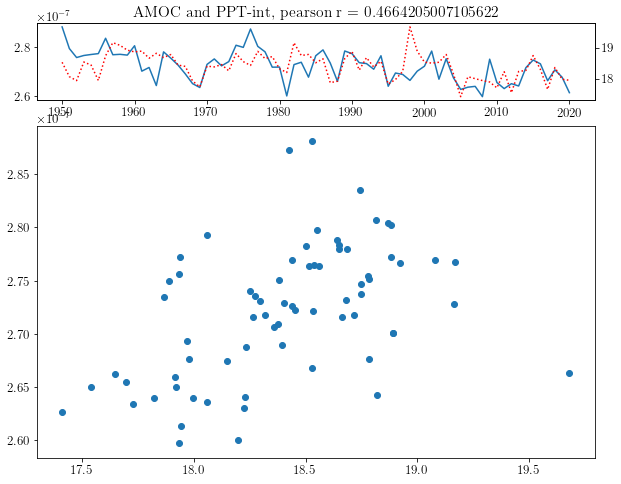

In [12]:
import matplotlib.gridspec as gridspec

# din = 0
# tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
# td = tmesh.gdept_1d[0,din].values
# print(td)
# typ = 'net'
# trac = 'DIC'


tdat = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = 'ATL').groupby('time_counter.year').mean()
amoc = RVA0_amoc.AMOC.sel(TIME=slice(f'{1950}-01-01', f'{2020}-12-31')).groupby('TIME.year').mean()


fig = plt.figure(figsize=(10, 8))

# Create a GridSpec with 3 rows and 1 column
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 2, 2])

# Create the top subplot, which will span the first row
ax1 = plt.subplot(gs[0])
axs0 = ax1.twinx()
ax1.plot(tdat.year, tdat, label = 'top 0')
axs0.plot(amoc.year,amoc, color = 'r', linestyle = ':')
pearson = correlation_coefficient, _ = pearsonr(amoc, tdat)
print(pearson)

tit = (f'AMOC and PPT-int, pearson r = {correlation_coefficient}')
plt.title(tit)
# Create the bottom subplot, which will span the next two rows
ax2 = plt.subplot(gs[1:])

ax2.scatter(amoc,tdat)

## yearly correlation

In [13]:
from scipy.stats import pearsonr
## 
RVA0_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_RVA0_1945-2022.nc')
amoc = RVA0_amoc.AMOC.sel(TIME=slice(f'{1950}-01-01', f'{2020}-12-31')).groupby('TIME.year').mean()
tdat = amoc
# Define the range of depths and latitudes
regs = ['ATL','NAH','NAM','NAL','NAT']
rows = ['NO3', 'Si', 'Fer', 'PHY', 'DIA-prop','PPINT','surf-Chl','EXP', 'Cflx']

# Initialize a DataFrame to hold the correlation coefficients
correlation_table = pd.DataFrame(index=regs, columns=rows)

# # Populate the table with correlation coefficients
for L in range(0,len(rows)):
    Li = (rows[L])
    print(Li)
        
    for d in range(0,len(regs)):
        reg = regs[d]
        
        if Li == 'NO3':
            tdat = ptrcD.regmean.sel(var = 'NO3').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
        if Li == 'Si':
            tdat = ptrcD.regmean.sel(var = 'Si').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
        if Li == 'Fer':
            tdat = ptrcD.regmean.sel(var = 'Fer').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
        if Li == 'PHY':
            DIA = ptrcD.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            MIX = ptrcD.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            COC = ptrcD.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            PIC = ptrcD.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            PHA = ptrcD.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            FIX = ptrcD.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            tdat = DIA + MIX + COC + PIC + PHA + FIX
        if Li == 'DIA-prop':
            DIA = ptrcD.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            MIX = ptrcD.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            COC = ptrcD.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            PIC = ptrcD.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            PHA = ptrcD.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            FIX = ptrcD.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            tdat = DIA/(DIA + MIX + COC + PIC + PHA + FIX)    
        if Li == 'PPINT':

            tdat = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'Cflx':

            tdat = diadD.regmeanf.sel(varf = 'Cflx').sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'surf-Chl':
            
            tdat = diadD.regmean.sel(var = 'TChl').isel(deptht = 0).sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'EXP':
            
            tdat = diadD.regmean.sel(var = 'EXP').isel(deptht = 9).sel(prov = reg).groupby('time_counter.year').mean()
            
        correlation_coefficient, p = pearsonr(amoc, tdat)
        print(f'{reg} {correlation_coefficient}, {p}')
        if p > 0.05:
            correlation_coefficient = 0
        correlation_table.at[reg, Li] = correlation_coefficient

correlation_table_a = correlation_table.apply(pd.to_numeric, errors='coerce')





NO3
ATL 0.3708933871836754, 0.0014519420705821906
NAH 0.10527071774010789, 0.38227443212317647
NAM 0.3217988523162601, 0.00620782169667934
NAL 0.11358297381584677, 0.3456113396297963
NAT 0.355224079888124, 0.00236698474495671
Si
ATL 0.33245741379980304, 0.004616159305661126
NAH 0.27072630052116164, 0.02240016195506267
NAM 0.26351967149231886, 0.026388249537044224
NAL 0.27089109200943634, 0.02231532176704001
NAT 0.44116339427090356, 0.00011771169957721338
Fer
ATL -0.20102887713772633, 0.09275485428250141
NAH -0.28280595902224304, 0.016863410155518215
NAM 0.029910864630346732, 0.8044321369534071
NAL -0.23009563876322925, 0.05355804080105997
NAT -0.08988825371968609, 0.4559823031552698
PHY
ATL 0.34696876408525706, 0.0030327475381220896
NAH 0.03563733041305611, 0.7679563353131541
NAM 0.2655454796397413, 0.02521080277927053
NAL 0.2471643196683448, 0.03770596187564887
NAT 0.46819713106426153, 3.831402197192622e-05
DIA-prop
ATL 0.19963930921479772, 0.09508152161922695
NAH 0.2130244349710712, 

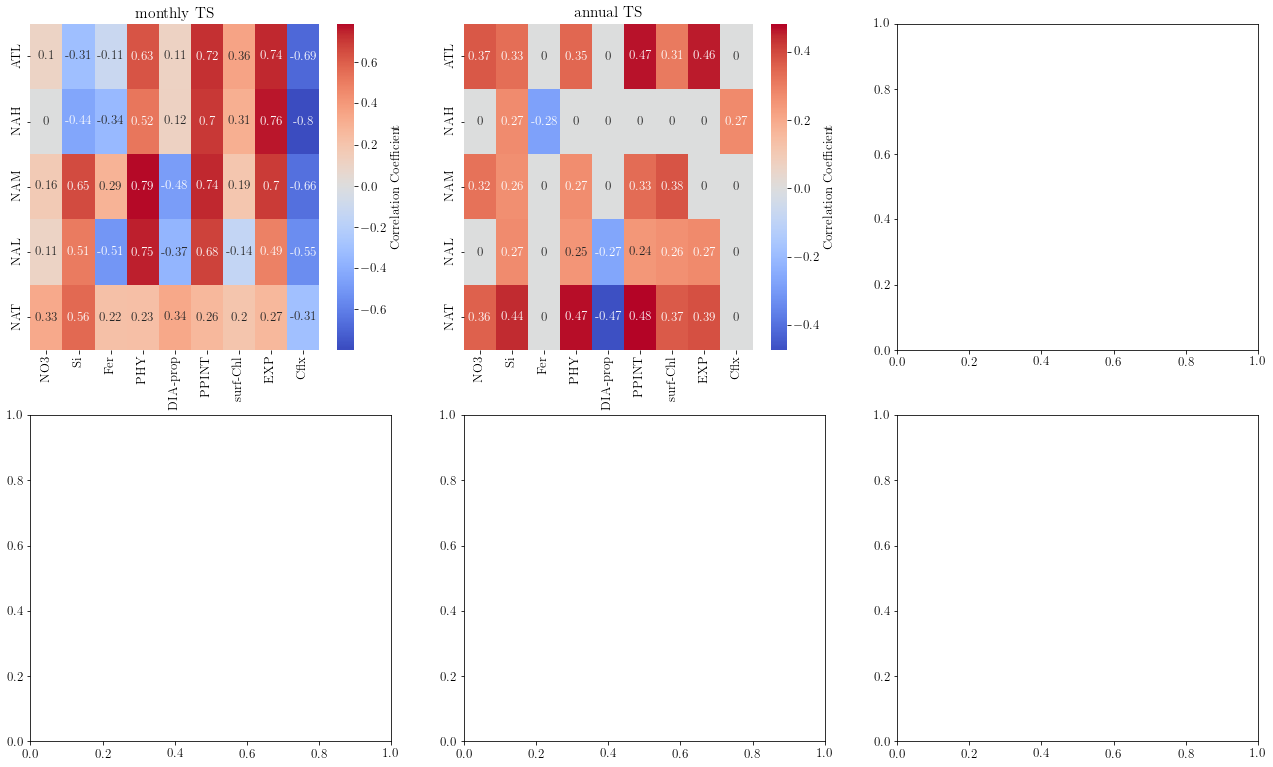

In [14]:
import seaborn as sns

fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(20*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

sns.heatmap(correlation_table_m, annot=True, cmap='coolwarm', center = 0,\
            cbar_kws={'label': 'Correlation Coefficient'}, ax = axs[0])
axs[0].set_title('monthly TS')

sns.heatmap(correlation_table_a, annot=True, cmap='coolwarm', center = 0,\
            cbar_kws={'label': 'Correlation Coefficient'}, ax = axs[1])
axs[1].set_title('annual TS')

# plt.xlabel('Categories')
# plt.ylabel('Groups')
plt.show()

In [15]:
tdat = diadD.regmean.sel(var = 'TChl').isel(deptht = 0).sel(prov = reg).sel(time_counter = diadD['time_counter.season'] == 'DJF').groupby('time_counter.year').mean()

[20.47114754 17.39245987 16.37580109 17.31725121 17.05170822 17.59308243
 18.78986549 16.75577164 15.43145752 16.896595   17.04538155 17.22989845
 17.87734413 16.50808144 17.06714058 16.15065384 16.44173813 16.41411972
 14.79543972 17.38063049 19.82335091 18.63530731 18.52010727 18.8719101
 16.15657997 18.32936668 16.56108475 17.37769699 18.65215683 17.07580757
 17.06832886 17.39993095 18.37940025 17.39886856 17.8486557  16.64383698
 18.70393372 18.23134422 17.01704788 17.47589493 17.60421753 16.8084507
 17.63103104 16.93591309 17.17888641 17.09907532 17.71620178 16.43526459
 18.0072155  17.99534035 15.95044994 17.25422287 17.4072876  16.71305275
 16.81525993 15.87837124 16.60080338 17.59449577 15.27670574 15.46929169
 16.91118431 17.4324894  16.86916161 17.35921478 17.41594315 17.03466034
 18.41107178 16.40178299 18.73790932 17.0244503  17.00846863 16.82189178
 19.31472969 17.27150726 15.77219486 17.87437057 17.85245705 15.71686268
 16.88036346 17.52596092 16.6836834  17.61320496 17.7

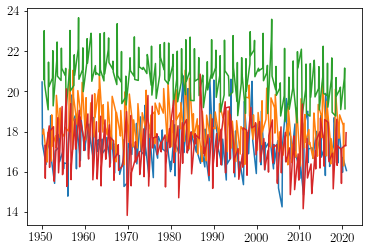

In [16]:
## 

tseas = ['DJF','MAM','JJA','SON']
plt.figure()
for s in tseas:
    RVA0_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_RVA0_1945-2022.nc')
    RVA0_amoc = RVA0_amoc.rename({"TIME": "time_counter"})
    amoc = RVA0_amoc.AMOC.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))
    amoc = amoc.sel(time_counter=amoc.time_counter.dt.season==s)
    print(amoc.values)
    plt.plot(amoc.time_counter, amoc)
    print(amoc.time_counter)

In [17]:
from scipy.stats import pearsonr
## 
RVA0_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_RVA0_1945-2022.nc')
amoc = RVA0_amoc.AMOC.sel(TIME=slice(f'{1950}-01-01', f'{2020}-12-31')).groupby('TIME.year').mean()
tdat = amoc
# Define the range of depths and latitudes
regs = ['ATL','NAH','NAM','NAL','NAT']
rows = ['NO3', 'Si', 'Fer', 'PHY', 'DIA-prop','PPINT','surf-Chl','EXP', 'Cflx']

# Initialize a DataFrame to hold the correlation coefficients
correlation_table = pd.DataFrame(index=regs, columns=rows)

# # Populate the table with correlation coefficients
for L in range(0,len(rows)):
    Li = (rows[L])
    print(Li)
        
    for d in range(0,len(regs)):
        reg = regs[d]
        
        if Li == 'NO3':
            tdat = ptrcD.regmean.sel(var = 'NO3').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
        if Li == 'Si':
            tdat = ptrcD.regmean.sel(var = 'Si').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
        if Li == 'Fer':
            tdat = ptrcD.regmean.sel(var = 'Fer').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
        if Li == 'PHY':
            DIA = ptrcD.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            MIX = ptrcD.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            COC = ptrcD.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            PIC = ptrcD.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            PHA = ptrcD.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            FIX = ptrcD.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            tdat = DIA + MIX + COC + PIC + PHA + FIX
        if Li == 'DIA-prop':
            DIA = ptrcD.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            MIX = ptrcD.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            COC = ptrcD.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            PIC = ptrcD.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            PHA = ptrcD.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            FIX = ptrcD.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
            tdat = DIA/(DIA + MIX + COC + PIC + PHA + FIX)    
        if Li == 'PPINT':

            tdat = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'Cflx':

            tdat = diadD.regmeanf.sel(varf = 'Cflx').sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'surf-Chl':
            
            tdat = diadD.regmean.sel(var = 'TChl').isel(deptht = 0).sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'EXP':
            
            tdat = diadD.regmean.sel(var = 'EXP').isel(deptht = 9).sel(prov = reg).groupby('time_counter.year').mean()
            
        correlation_coefficient, p = pearsonr(amoc, tdat)
        print(f'{reg} {correlation_coefficient}, {p}')
        if p > 0.05:
            correlation_coefficient = 0
        correlation_table.at[reg, Li] = correlation_coefficient

correlation_table_a = correlation_table.apply(pd.to_numeric, errors='coerce')





NO3
ATL 0.3708933871836754, 0.0014519420705821906
NAH 0.10527071774010789, 0.38227443212317647
NAM 0.3217988523162601, 0.00620782169667934
NAL 0.11358297381584677, 0.3456113396297963
NAT 0.355224079888124, 0.00236698474495671
Si
ATL 0.33245741379980304, 0.004616159305661126
NAH 0.27072630052116164, 0.02240016195506267
NAM 0.26351967149231886, 0.026388249537044224
NAL 0.27089109200943634, 0.02231532176704001
NAT 0.44116339427090356, 0.00011771169957721338
Fer
ATL -0.20102887713772633, 0.09275485428250141
NAH -0.28280595902224304, 0.016863410155518215
NAM 0.029910864630346732, 0.8044321369534071
NAL -0.23009563876322925, 0.05355804080105997
NAT -0.08988825371968609, 0.4559823031552698
PHY
ATL 0.34696876408525706, 0.0030327475381220896
NAH 0.03563733041305611, 0.7679563353131541
NAM 0.2655454796397413, 0.02521080277927053
NAL 0.2471643196683448, 0.03770596187564887
NAT 0.46819713106426153, 3.831402197192622e-05
DIA-prop
ATL 0.19963930921479772, 0.09508152161922695
NAH 0.2130244349710712, 

In [18]:
from scipy.stats import pearsonr

s = 'DJF'

RVA0_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_RVA0_1945-2022.nc')
RVA0_amoc = RVA0_amoc.rename({"TIME": "time_counter"})
amoc = RVA0_amoc.AMOC.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))
amoc = amoc.sel(time_counter=amoc.time_counter.dt.season==s).groupby('time_counter.year').mean()
print(len(amoc))

# Define the range of depths and latitudes
regs = ['ATL','NAH','NAM','NAL','NAT']
rows = ['NO3', 'Si', 'Fer', 'PHY', 'DIA-prop','PPINT','surf-Chl','EXP', 'Cflx']

# Initialize a DataFrame to hold the correlation coefficients
correlation_table = pd.DataFrame(index=regs, columns=rows)

# # Populate the table with correlation coefficients
for L in range(0,len(rows)):
    Li = (rows[L])
    print(Li)
        
    for d in range(0,len(regs)):
        reg = regs[d]
        
        if Li == 'NO3':
            tdat = ptrcD.regmean.sel(var = 'NO3').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            print(len(tdat))
        if Li == 'Si':
            tdat = ptrcD.regmean.sel(var = 'Si').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
        if Li == 'Fer':
            tdat = ptrcD.regmean.sel(var = 'Fer').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
        if Li == 'PHY':
            DIA = ptrcD.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            MIX = ptrcD.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            COC = ptrcD.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PIC = ptrcD.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PHA = ptrcD.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            FIX = ptrcD.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            tdat = DIA + MIX + COC + PIC + PHA + FIX
        if Li == 'DIA-prop':
            DIA = ptrcD.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            MIX = ptrcD.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            COC = ptrcD.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PIC = ptrcD.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PHA = ptrcD.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            FIX = ptrcD.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            tdat = DIA/(DIA + MIX + COC + PIC + PHA + FIX)    
        if Li == 'PPINT':

            tdat = diadD.regmeanf.sel(varf = 'PPINT')\
            .sel(time_counter = ptrcD['time_counter.season'] == s).sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'Cflx':

            tdat = diadD.regmeanf.sel(varf = 'Cflx')\
            .sel(time_counter = ptrcD['time_counter.season'] == s).sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'surf-Chl':
            
            tdat = diadD.regmean.sel(var = 'TChl')\
            .sel(time_counter = diadD['time_counter.season'] == s).isel(deptht = 0).sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'EXP':
            
            tdat = diadD.regmean.sel(var = 'EXP')\
            .sel(time_counter = diadD['time_counter.season'] == s).isel(deptht = 9).sel(prov = reg).groupby('time_counter.year').mean()
    
            
            
        correlation_coefficient, p = pearsonr(amoc, tdat)
        print(f'{reg} {correlation_coefficient}, {p}')
        if p > 0.05:
            correlation_coefficient = 0
        correlation_table.at[reg, Li] = correlation_coefficient

correlation_table_DJF = correlation_table.apply(pd.to_numeric, errors='coerce')




71
NO3
71
ATL 0.14131436473167097, 0.23979056091048104
71
NAH 0.06743170665345369, 0.5763385740490652
71
NAM 0.04027727998985692, 0.7387616223113664
71
NAL -0.10247758646503721, 0.39509911813688253
71
NAT 0.2890310267968068, 0.014500859097058451
Si
ATL 0.0884120863063632, 0.4634439163759885
NAH 0.08490062791111427, 0.4814577682782921
NAM -0.027898093648984323, 0.817356841973442
NAL 0.1503904741056855, 0.21062323680547318
NAT 0.2132843173049156, 0.07411925059809608
Fer
ATL -0.10333104777382374, 0.3911537193107003
NAH -0.13852537265004983, 0.2492875244569212
NAM -0.09645034207894232, 0.42362535918103233
NAL -0.043801982898825115, 0.7168252457424665
NAT -0.04128457739530647, 0.7324704494488561
PHY
ATL 0.3646496851840164, 0.0017692412265324824
NAH 0.15342350195259202, 0.20146074259425176
NAM 0.051301246157689585, 0.6709247941691585
NAL 0.3334622630299589, 0.004486630933654214
NAT 0.3052070412841942, 0.009649481355555196
DIA-prop
ATL -0.13774507061086172, 0.2519899855642344
NAH -0.038764792

In [19]:
from scipy.stats import pearsonr

s = 'MAM'

RVA0_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_RVA0_1945-2022.nc')
RVA0_amoc = RVA0_amoc.rename({"TIME": "time_counter"})
amoc = RVA0_amoc.AMOC.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))
amoc = amoc.sel(time_counter=amoc.time_counter.dt.season==s).groupby('time_counter.year').mean()
print(len(amoc))

# Define the range of depths and latitudes
regs = ['ATL','NAH','NAM','NAL','NAT']
rows = ['NO3', 'Si', 'Fer', 'PHY', 'DIA-prop','PPINT','surf-Chl','EXP', 'Cflx']

# Initialize a DataFrame to hold the correlation coefficients
correlation_table = pd.DataFrame(index=regs, columns=rows)

# # Populate the table with correlation coefficients
for L in range(0,len(rows)):
    Li = (rows[L])
    print(Li)
        
    for d in range(0,len(regs)):
        reg = regs[d]
        
        if Li == 'NO3':
            tdat = ptrcD.regmean.sel(var = 'NO3').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            print(len(tdat))
        if Li == 'Si':
            tdat = ptrcD.regmean.sel(var = 'Si').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
        if Li == 'Fer':
            tdat = ptrcD.regmean.sel(var = 'Fer').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
        if Li == 'PHY':
            DIA = ptrcD.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            MIX = ptrcD.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            COC = ptrcD.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PIC = ptrcD.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PHA = ptrcD.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            FIX = ptrcD.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            tdat = DIA + MIX + COC + PIC + PHA + FIX
        if Li == 'DIA-prop':
            DIA = ptrcD.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            MIX = ptrcD.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            COC = ptrcD.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PIC = ptrcD.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PHA = ptrcD.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            FIX = ptrcD.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            tdat = DIA/(DIA + MIX + COC + PIC + PHA + FIX)    
        if Li == 'PPINT':

            tdat = diadD.regmeanf.sel(varf = 'PPINT')\
            .sel(time_counter = ptrcD['time_counter.season'] == s).sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'Cflx':

            tdat = diadD.regmeanf.sel(varf = 'Cflx')\
            .sel(time_counter = ptrcD['time_counter.season'] == s).sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'surf-Chl':
            
            tdat = diadD.regmean.sel(var = 'TChl')\
            .sel(time_counter = diadD['time_counter.season'] == s).isel(deptht = 0).sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'EXP':
            
            tdat = diadD.regmean.sel(var = 'EXP')\
            .sel(time_counter = diadD['time_counter.season'] == s).isel(deptht = 9).sel(prov = reg).groupby('time_counter.year').mean()
    
            
            
        correlation_coefficient, p = pearsonr(amoc, tdat)
        print(f'{reg} {correlation_coefficient}, {p}')
        if p > 0.05:
            correlation_coefficient = 0
        correlation_table.at[reg, Li] = correlation_coefficient

correlation_table_MAM = correlation_table.apply(pd.to_numeric, errors='coerce')




71
NO3
71
ATL 0.2505920112309953, 0.035047911259687786
71
NAH -0.06654373715538897, 0.5813823485169
71
NAM 0.36731963635036724, 0.0016266272875307326
71
NAL 0.17075550898819206, 0.1545180560192333
71
NAT 0.0907691380669163, 0.45156136459732327
Si
ATL 0.3587048229391554, 0.002127916601612961
NAH 0.3018427593315429, 0.01052165529527861
NAM 0.34328014037557253, 0.003380814612788276
NAL 0.03950037566970156, 0.7436255891454173
NAT 0.1498443703350958, 0.21230379530427876
Fer
ATL -0.19103956084806656, 0.11051297433650117
NAH -0.3250836204614719, 0.005672353810070126
NAM 0.04678723895195435, 0.6984224332685767
NAL -0.14394224503546105, 0.2310732463751593
NAT -0.11410609682288482, 0.34337982056294414
PHY
ATL -0.060445103425045846, 0.6165559967035055
NAH -0.1431996470739687, 0.23351398377505625
NAM 0.24591762042679566, 0.038713419832362976
NAL 0.08549431627196957, 0.47838620280524125
NAT 0.01729366298799588, 0.8861771255354964
DIA-prop
ATL 0.20988916535400126, 0.0789533183364384
NAH 0.2109075991

In [20]:
from scipy.stats import pearsonr

s = 'JJA'

RVA0_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_RVA0_1945-2022.nc')
RVA0_amoc = RVA0_amoc.rename({"TIME": "time_counter"})
amoc = RVA0_amoc.AMOC.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))
amoc = amoc.sel(time_counter=amoc.time_counter.dt.season==s).groupby('time_counter.year').mean()
print(len(amoc))

# Define the range of depths and latitudes
regs = ['ATL','NAH','NAM','NAL','NAT']
rows = ['NO3', 'Si', 'Fer', 'PHY', 'DIA-prop','PPINT','surf-Chl','EXP', 'Cflx']

# Initialize a DataFrame to hold the correlation coefficients
correlation_table = pd.DataFrame(index=regs, columns=rows)

# # Populate the table with correlation coefficients
for L in range(0,len(rows)):
    Li = (rows[L])
    print(Li)
        
    for d in range(0,len(regs)):
        reg = regs[d]
        
        if Li == 'NO3':
            tdat = ptrcD.regmean.sel(var = 'NO3').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            print(len(tdat))
        if Li == 'Si':
            tdat = ptrcD.regmean.sel(var = 'Si').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
        if Li == 'Fer':
            tdat = ptrcD.regmean.sel(var = 'Fer').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
        if Li == 'PHY':
            DIA = ptrcD.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            MIX = ptrcD.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            COC = ptrcD.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PIC = ptrcD.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PHA = ptrcD.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            FIX = ptrcD.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            tdat = DIA + MIX + COC + PIC + PHA + FIX
        if Li == 'DIA-prop':
            DIA = ptrcD.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            MIX = ptrcD.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            COC = ptrcD.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PIC = ptrcD.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PHA = ptrcD.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            FIX = ptrcD.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            tdat = DIA/(DIA + MIX + COC + PIC + PHA + FIX)    
        if Li == 'PPINT':

            tdat = diadD.regmeanf.sel(varf = 'PPINT')\
            .sel(time_counter = ptrcD['time_counter.season'] == s).sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'Cflx':

            tdat = diadD.regmeanf.sel(varf = 'Cflx')\
            .sel(time_counter = ptrcD['time_counter.season'] == s).sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'surf-Chl':
            
            tdat = diadD.regmean.sel(var = 'TChl')\
            .sel(time_counter = diadD['time_counter.season'] == s).isel(deptht = 0).sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'EXP':
            
            tdat = diadD.regmean.sel(var = 'EXP')\
            .sel(time_counter = diadD['time_counter.season'] == s).isel(deptht = 9).sel(prov = reg).groupby('time_counter.year').mean()
    
            
            
        correlation_coefficient, p = pearsonr(amoc, tdat)
        print(f'{reg} {correlation_coefficient}, {p}')
        if p > 0.05:
            correlation_coefficient = 0
        correlation_table.at[reg, Li] = correlation_coefficient

correlation_table_JJA = correlation_table.apply(pd.to_numeric, errors='coerce')




71
NO3
71
ATL 0.2314786221978473, 0.05209821017416125
71
NAH -0.03756584921461721, 0.7557802677663703
71
NAM 0.30331765087968277, 0.010131196462021841
71
NAL 0.17062371191200076, 0.15484129154357434
71
NAT 0.13578951489478763, 0.258850303613227
Si
ATL 0.287954838414777, 0.014887616928002657
NAH 0.13451617566752455, 0.263384754681686
NAM 0.3152923630877633, 0.007401315797390939
NAL 0.3189903597651166, 0.006700441315774819
NAT 0.2430495179274679, 0.041116272965190194
Fer
ATL -0.16860782796957757, 0.15984807342564808
NAH -0.38276840799595957, 0.0009861790278791014
NAM -0.06501890607229793, 0.5900903529276352
NAL -0.16655264614749932, 0.16507469979140324
NAT -0.005766231312320624, 0.9619353389859036
PHY
ATL 0.34706880776670457, 0.0030237697101106074
NAH 0.11890281363279924, 0.3233395382868481
NAM 0.26923957417725775, 0.023178053590343167
NAL 0.3325503058090363, 0.0046040478337965665
NAT 0.1597987008604164, 0.18313644516223257
DIA-prop
ATL 0.22060103879964338, 0.0645055337777339
NAH 0.26740

In [21]:
from scipy.stats import pearsonr

s = 'SON'

RVA0_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_RVA0_1945-2022.nc')
RVA0_amoc = RVA0_amoc.rename({"TIME": "time_counter"})
amoc = RVA0_amoc.AMOC.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))
amoc = amoc.sel(time_counter=amoc.time_counter.dt.season==s).groupby('time_counter.year').mean()
print(len(amoc))

# Define the range of depths and latitudes
regs = ['ATL','NAH','NAM','NAL','NAT']
rows = ['NO3', 'Si', 'Fer', 'PHY', 'DIA-prop','PPINT','surf-Chl','EXP', 'Cflx']

# Initialize a DataFrame to hold the correlation coefficients
correlation_table = pd.DataFrame(index=regs, columns=rows)

# # Populate the table with correlation coefficients
for L in range(0,len(rows)):
    Li = (rows[L])
    print(Li)
        
    for d in range(0,len(regs)):
        reg = regs[d]
        
        if Li == 'NO3':
            tdat = ptrcD.regmean.sel(var = 'NO3').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            print(len(tdat))
        if Li == 'Si':
            tdat = ptrcD.regmean.sel(var = 'Si').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
        if Li == 'Fer':
            tdat = ptrcD.regmean.sel(var = 'Fer').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
        if Li == 'PHY':
            DIA = ptrcD.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            MIX = ptrcD.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            COC = ptrcD.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PIC = ptrcD.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PHA = ptrcD.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            FIX = ptrcD.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            tdat = DIA + MIX + COC + PIC + PHA + FIX
        if Li == 'DIA-prop':
            DIA = ptrcD.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            MIX = ptrcD.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            COC = ptrcD.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PIC = ptrcD.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            PHA = ptrcD.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            FIX = ptrcD.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).\
            mean(dim = 'deptht').sel(time_counter = ptrcD['time_counter.season'] == s).groupby('time_counter.year').mean()
            tdat = DIA/(DIA + MIX + COC + PIC + PHA + FIX)    
        if Li == 'PPINT':

            tdat = diadD.regmeanf.sel(varf = 'PPINT')\
            .sel(time_counter = ptrcD['time_counter.season'] == s).sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'Cflx':

            tdat = diadD.regmeanf.sel(varf = 'Cflx')\
            .sel(time_counter = ptrcD['time_counter.season'] == s).sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'surf-Chl':
            
            tdat = diadD.regmean.sel(var = 'TChl')\
            .sel(time_counter = diadD['time_counter.season'] == s).isel(deptht = 0).sel(prov = reg).groupby('time_counter.year').mean()
            
        if Li == 'EXP':
            
            tdat = diadD.regmean.sel(var = 'EXP')\
            .sel(time_counter = diadD['time_counter.season'] == s).isel(deptht = 9).sel(prov = reg).groupby('time_counter.year').mean()
    
            
            
        correlation_coefficient, p = pearsonr(amoc, tdat)
        print(f'{reg} {correlation_coefficient}, {p}')
        if p > 0.05:
            correlation_coefficient = 0
        correlation_table.at[reg, Li] = correlation_coefficient

correlation_table_SON = correlation_table.apply(pd.to_numeric, errors='coerce')




71
NO3
71
ATL 0.24014596559557047, 0.04367339511873291
71
NAH 0.18421075143292245, 0.1240904057533065
71
NAM 0.11881306190068737, 0.323707526127242
71
NAL 0.03162787718364249, 0.7934476311983485
71
NAT 0.22037690896941106, 0.06478428774639977
Si
ATL 0.1334143282142125, 0.2673515294300627
NAH 0.11700543269909623, 0.33117569349325093
NAM 0.037713346856177325, 0.7548514091393793
NAL 0.014632366295994306, 0.9036019413380557
NAT 0.3390613329466288, 0.003822154633966719
Fer
ATL -0.0578935740416569, 0.6315376757721837
NAH 0.0077776252836086815, 0.948673120669894
NAM 0.11995651169377333, 0.31903926432275653
NAL -0.22844856047164017, 0.05534004800260001
NAT -0.01911322037469005, 0.87429398668305
PHY
ATL 0.2445804559826788, 0.03981874372362007
NAH 0.12155210155550195, 0.31259750350109056
NAM 0.06141033082829174, 0.6109285509339402
NAL -0.02859357053530634, 0.8128852603248252
NAT 0.26161211077569546, 0.02753911946135945
DIA-prop
ATL -0.07552306131789188, 0.5313359020658021
NAH 0.00776063087732851

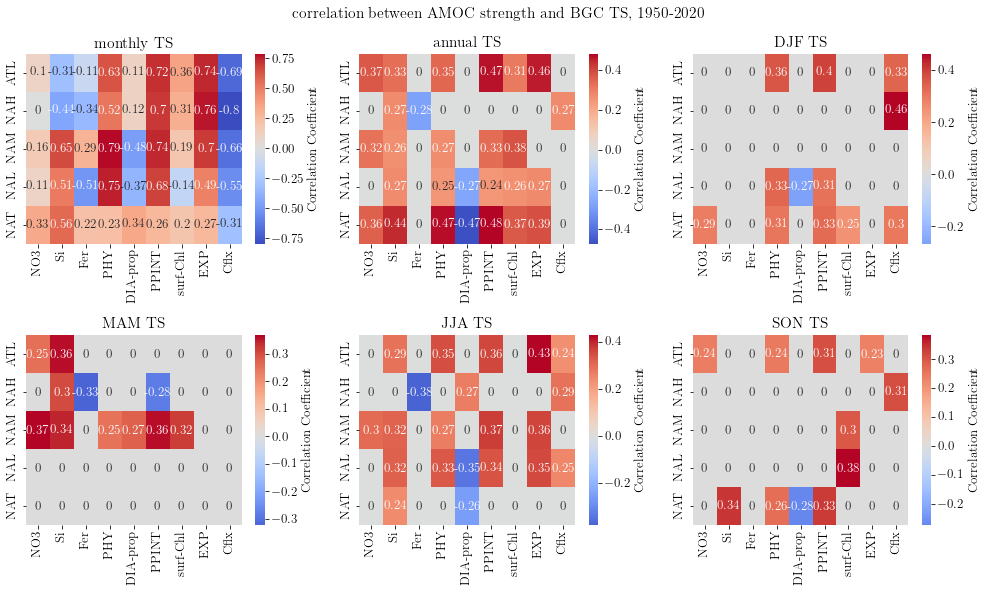

In [22]:
import seaborn as sns

fact = 0.7
fig, axs = plt.subplots(2,3, figsize=(20*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

sns.heatmap(correlation_table_m, annot=True, cmap='coolwarm', center = 0,\
            cbar_kws={'label': 'Correlation Coefficient'}, ax = axs[0])
axs[0].set_title('monthly TS')

sns.heatmap(correlation_table_a, annot=True, cmap='coolwarm', center = 0,\
            cbar_kws={'label': 'Correlation Coefficient'}, ax = axs[1])
axs[1].set_title('annual TS')

sns.heatmap(correlation_table_DJF, annot=True, cmap='coolwarm', center = 0,\
            cbar_kws={'label': 'Correlation Coefficient'}, ax = axs[2])
axs[2].set_title('DJF TS')

sns.heatmap(correlation_table_MAM, annot=True, cmap='coolwarm', center = 0,\
            cbar_kws={'label': 'Correlation Coefficient'}, ax = axs[3])
axs[3].set_title('MAM TS')

sns.heatmap(correlation_table_JJA, annot=True, cmap='coolwarm', center = 0,\
            cbar_kws={'label': 'Correlation Coefficient'}, ax = axs[4])
axs[4].set_title('JJA TS')


sns.heatmap(correlation_table_SON, annot=True, cmap='coolwarm', center = 0,\
            cbar_kws={'label': 'Correlation Coefficient'}, ax = axs[5])
axs[5].set_title('SON TS')

# plt.xlabel('Categories')
# plt.ylabel('Groups')

plt.suptitle('correlation between AMOC strength and BGC TS, 1950-2020')
plt.tight_layout()
plt.show()



Alkalini
DIC
NO3
Si
PO4
Fer
DIA
MIX
COC
PIC
PHA
FIX


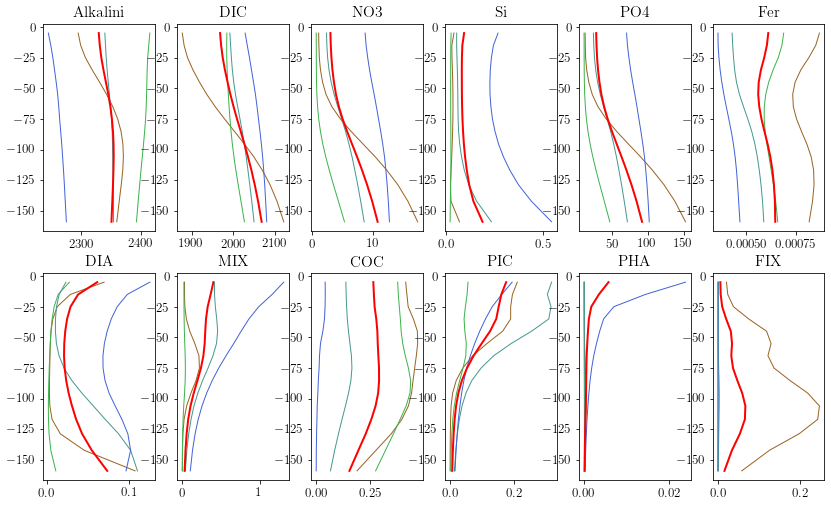

In [23]:
ptrcD

fact = 0.7
fig, axs = plt.subplots(2,6, figsize=(20*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tvars = ['Alkalini', 'DIC', 'NO3', 'Si', 'PO4', 'Fer', 'DIA', 'MIX', 'COC', 'PIC', 'PHA', 'FIX', 'BSi', 'GON']

regs = ['NAT', 'NAL', 'NAM', 'NAH', 'ATL']
lws = [1,1,1,1,2]

for t in range(0,12):
    tvar = tvars[t]
    print(tvar)
    for r in range(0,5):
        reg = regs[r]; lw = lws[r]; col = regdict[reg]['color']

        tvark = ptrcD.sel(var = tvar).isel(deptht = range(0,15)).sel(prov = reg).mean(dim = 'time_counter')

        axs[t].plot(tvark.regmean*1e6, -tvark.deptht, \
                    linestyle = '-', linewidth = lw, color = col, label = reg)
    axs[t].set_title(tvar)

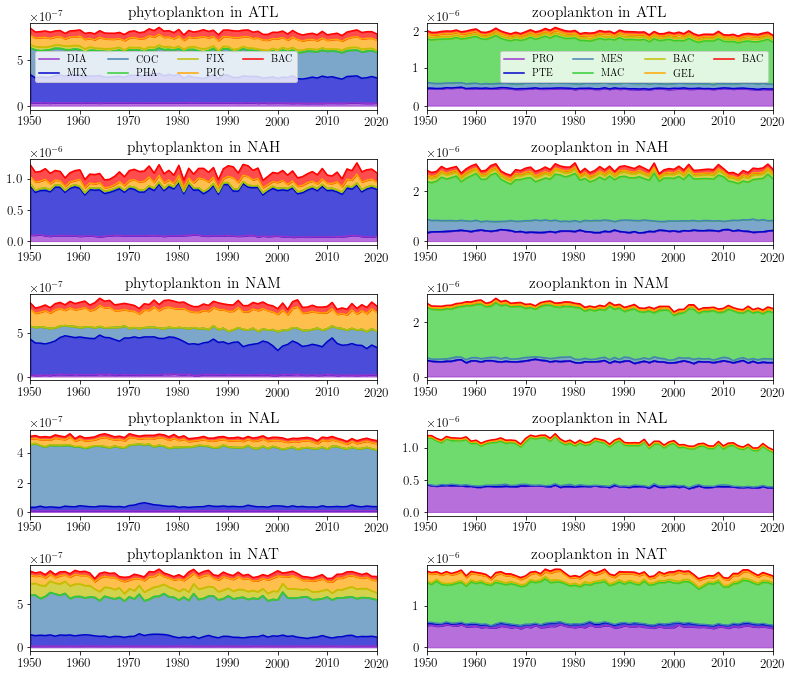

In [24]:
fact = 0.8
fig, axs = plt.subplots(5,2, figsize=(14*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

regs = ['ATL','NAH', 'NAM','NAL','NAT',]

for r in range(0,5):
    reg = regs[r]; lw = lws[r]; col = regdict[reg]['color']
    DIA = ptrc.regmean.sel(var = 'DIA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
    year = DIA.year.values
    MIX = ptrc.regmean.sel(var = 'MIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
    COC = ptrc.regmean.sel(var = 'COC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
    PIC = ptrc.regmean.sel(var = 'PIC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
    PHA = ptrc.regmean.sel(var = 'PHA').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
    FIX = ptrc.regmean.sel(var = 'FIX').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
    BAC = ptrc.regmean.sel(var = 'BAC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()

    i = r+1
    axs[(i-1)*2].plot(year,DIA, color = 'darkorchid', label = 'DIA')
    axs[(i-1)*2].plot(year,DIA+MIX, color = 'mediumblue', label = 'MIX')
    axs[(i-1)*2].plot(year,DIA+MIX+COC, color = 'steelblue', label = 'COC')
    axs[(i-1)*2].plot(year,DIA+MIX+COC+PHA, color = 'limegreen', label = 'PHA')
    axs[(i-1)*2].plot(year,DIA+MIX+COC+PHA+FIX, color = 'y', label = 'FIX')
    axs[(i-1)*2].plot(year,DIA+MIX+COC+PHA+FIX+PIC, color = 'orange', label = 'PIC')
    axs[(i-1)*2].plot(year,DIA+MIX+COC+PHA+FIX+PIC+BAC, color = 'r', label = 'BAC')
    
    axs[(i-1)*2].fill_between(year,DIA, 0, color = 'darkorchid', alpha = 0.7)
    axs[(i-1)*2].fill_between(year,DIA+MIX, DIA, color = 'mediumblue', alpha = 0.7)
    axs[(i-1)*2].fill_between(year,DIA+MIX+COC, DIA+MIX, color = 'steelblue', alpha = 0.7)
    axs[(i-1)*2].fill_between(year,DIA+MIX+COC+PHA, DIA+MIX+COC, color = 'limegreen', alpha = 0.7)
    axs[(i-1)*2].fill_between(year,DIA+MIX+COC+PHA+FIX, DIA+MIX+COC+PHA, color = 'y', alpha = 0.7)
    axs[(i-1)*2].fill_between(year,DIA+MIX+COC+PHA+FIX+PIC, DIA+MIX+COC+PHA+FIX, color = 'orange', alpha = 0.7)
    axs[(i-1)*2].fill_between(year,DIA+MIX+COC+PHA+FIX+PIC+BAC, DIA+MIX+COC+PHA+FIX+PIC, color = 'r', alpha = 0.7)
    axs[(i-1)*2].set_title(f'phytoplankton in {reg}')
    
    
    ###
    PRO = ptrc.regmean.sel(var = 'PRO').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
    year = PRO.year.values
    PTE = ptrc.regmean.sel(var = 'PTE').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
    MES = ptrc.regmean.sel(var = 'MES').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
    GEL = ptrc.regmean.sel(var = 'GEL').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
    MAC = ptrc.regmean.sel(var = 'MAC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()
    BAC = ptrc.regmean.sel(var = 'BAC').isel(deptht = range(0,10)).sel(prov = reg).mean(dim = 'deptht').groupby('time_counter.year').mean()

    i = r+1
    axs[(i-1)*2+1].plot(year,PRO, color = 'darkorchid', label = 'PRO')
    axs[(i-1)*2+1].plot(year,PRO+PTE, color = 'mediumblue', label = 'PTE')
    axs[(i-1)*2+1].plot(year,PRO+PTE+MES, color = 'steelblue', label = 'MES')
    axs[(i-1)*2+1].plot(year,PRO+PTE+MES+MAC, color = 'limegreen', label = 'MAC')
    axs[(i-1)*2+1].plot(year,PRO+PTE+MES+MAC+BAC, color = 'y', label = 'BAC')
    axs[(i-1)*2+1].plot(year,PRO+PTE+MES+MAC+BAC+GEL, color = 'orange', label = 'GEL')
    axs[(i-1)*2+1].plot(year,PRO+PTE+MES+MAC+BAC+GEL+BAC, color = 'r', label = 'BAC')
    
    axs[(i-1)*2+1].fill_between(year,PRO, 0, color = 'darkorchid', alpha = 0.7)
    axs[(i-1)*2+1].fill_between(year,PRO+PTE, PRO, color = 'mediumblue', alpha = 0.7)
    axs[(i-1)*2+1].fill_between(year,PRO+PTE+MES, PRO+PTE, color = 'steelblue', alpha = 0.7)
    axs[(i-1)*2+1].fill_between(year,PRO+PTE+MES+MAC, PRO+PTE+MES, color = 'limegreen', alpha = 0.7)
    axs[(i-1)*2+1].fill_between(year,PRO+PTE+MES+MAC+BAC, PRO+PTE+MES+MAC, color = 'y', alpha = 0.7)
    axs[(i-1)*2+1].fill_between(year,PRO+PTE+MES+MAC+BAC+GEL, PRO+PTE+MES+MAC+BAC, color = 'orange', alpha = 0.7)
    axs[(i-1)*2+1].fill_between(year,PRO+PTE+MES+MAC+BAC+GEL+BAC, PRO+PTE+MES+MAC+BAC+GEL, color = 'r', alpha = 0.7)
    axs[(i-1)*2+1].set_title(f'zooplankton in {reg}')
    axs[(i-1)*2+1].set_xlim([1950,2020])
    axs[(i-1)*2].set_xlim([1950,2020])
axs[0].legend(ncol = 4, fontsize = 10)
axs[1].legend(ncol = 4, fontsize = 10)
plt.tight_layout()

### do systematic nitrogen transports correlate with ppt? if so where?

In [25]:
def make_yearlist(yrst, yrend, dtype, tr, bd):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/transports/{tr}_{yrs[i]}_{dtype}_row{bd}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

RVA0_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_RVA0_1945-2022.nc')

def make_yearlist2(yrst, yrend, dtype, mod = 'RVA0'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/{mod}_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

diadD = xr.open_mfdataset(make_yearlist2(1950,2020,'diad', 'RVD0'))

Text(0.5, 0.98, 'correlation between net NO3 transport (depth 0:d) in a province and PPINT in that province')

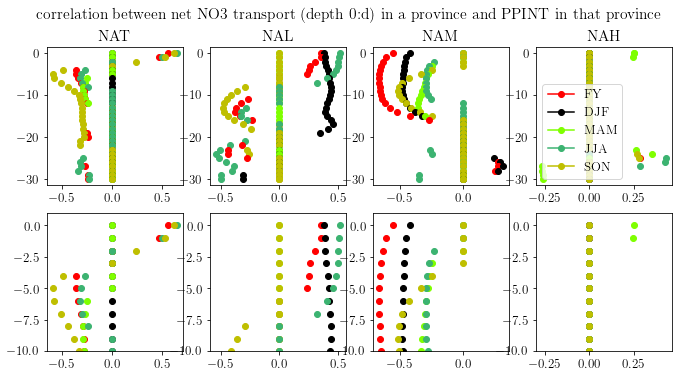

In [26]:
tseas = ['FY','DJF','MAM','JJA','SON']

tbd = 73; tprov = 'NAT'
tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'NO3', 'RVA0', bd = tbd))
tcor_no3_ppint_NAT = np.zeros([31,5])

for d in range(0,31):

    for s in range(0,5):
        seas = tseas[s]
        
        if seas == 'FY':
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)
        else:
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
            .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)            
        if p > 0.05:
            correlation_coefficient = 0

        tcor_no3_ppint_NAT[d,s] = correlation_coefficient
        
###
tbd = 90; tprov = 'NAL'
tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'NO3', 'RVA0', bd = tbd))
tcor_no3_ppint_NAL = np.zeros([31,5])

for d in range(0,31):

    for s in range(0,5):
        seas = tseas[s]
        
        if seas == 'FY':
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)
        else:
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
            .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)            
        if p > 0.05:
            correlation_coefficient = 0

        tcor_no3_ppint_NAL[d,s] = correlation_coefficient
        
        
tbd = 100; tprov = 'NAM'
tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'NO3', 'RVA0', bd = tbd))
tcor_no3_ppint_NAM = np.zeros([31,5])

for d in range(0,31):

    for s in range(0,5):
        seas = tseas[s]
        
        if seas == 'FY':
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)
        else:
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
            .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)            
        if p > 0.05:
            correlation_coefficient = 0

        tcor_no3_ppint_NAM[d,s] = correlation_coefficient
        
        
tbd = 109; tprov = 'NAH'
tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'NO3', 'RVA0', bd = tbd))
tcor_no3_ppint_NAH = np.zeros([31,5])

for d in range(0,31):

    for s in range(0,5):
        seas = tseas[s]
        
        if seas == 'FY':
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)
        else:
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
            .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)            
        if p > 0.05:
            correlation_coefficient = 0

        tcor_no3_ppint_NAH[d,s] = correlation_coefficient
        
        
tseas = ['FY','DJF','MAM','JJA','SON']

fact = 0.7
fig, axs = plt.subplots(2,4, figsize=(16*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

cols = ['r','k','chartreuse','mediumseagreen','y']
labs = ['F']


for i in range(0,31):
    for s in range(0,5):
        axs[0].plot(tcor_no3_ppint_NAT[i,s],-i, marker = 'o', color = cols[s])
        axs[4].plot(tcor_no3_ppint_NAT[i,s],-i, marker = 'o', color = cols[s])

        axs[1].plot(tcor_no3_ppint_NAL[i,s],-i, marker = 'o', color = cols[s])
        axs[5].plot(tcor_no3_ppint_NAL[i,s],-i, marker = 'o', color = cols[s])
        
        axs[2].plot(tcor_no3_ppint_NAM[i,s],-i, marker = 'o', color = cols[s])
        axs[6].plot(tcor_no3_ppint_NAM[i,s],-i, marker = 'o', color = cols[s])
        
        if i == 0:
            axs[3].plot(tcor_no3_ppint_NAH[i,s],-i, marker = 'o', color = cols[s], label = tseas[s])
        axs[3].plot(tcor_no3_ppint_NAH[i,s],-i, marker = 'o', color = cols[s])
        axs[7].plot(tcor_no3_ppint_NAH[i,s],-i, marker = 'o', color = cols[s])
for i in range(4,8):
    axs[i].set_ylim([-10,1])
    
tits = ['NAT','NAL','NAM','NAH']


for i in range(0,4):
    axs[i].set_title(tits[i])

axs[3].legend()

plt.suptitle('correlation between net NO3 transport (depth 0:d) in a province and PPINT in that province')

In [27]:
# tseas = ['FY','DJF','MAM','JJA','SON']

# tbd = 73; tprov = 'NAT'
# tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'PO4', 'RVA0', bd = tbd))
# tcor_PO4_ppint_NAT = np.zeros([31,5])

# for d in range(0,31):

#     for s in range(0,5):
#         seas = tseas[s]
        
#         if seas == 'FY':
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)
#         else:
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
#             .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)            
#         if p > 0.05:
#             correlation_coefficient = 0

#         tcor_PO4_ppint_NAT[d,s] = correlation_coefficient
        
# ###
# tbd = 90; tprov = 'NAL'
# tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'PO4', 'RVA0', bd = tbd))
# tcor_PO4_ppint_NAL = np.zeros([31,5])

# for d in range(0,31):

#     for s in range(0,5):
#         seas = tseas[s]
        
#         if seas == 'FY':
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)
#         else:
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
#             .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)            
#         if p > 0.05:
#             correlation_coefficient = 0

#         tcor_PO4_ppint_NAL[d,s] = correlation_coefficient
        
        
# tbd = 100; tprov = 'NAM'
# tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'PO4', 'RVA0', bd = tbd))
# tcor_PO4_ppint_NAM = np.zeros([31,5])

# for d in range(0,31):

#     for s in range(0,5):
#         seas = tseas[s]
        
#         if seas == 'FY':
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)
#         else:
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
#             .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)            
#         if p > 0.05:
#             correlation_coefficient = 0

#         tcor_PO4_ppint_NAM[d,s] = correlation_coefficient
        
        
# tbd = 109; tprov = 'NAH'
# tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'PO4', 'RVA0', bd = tbd))
# tcor_PO4_ppint_NAH = np.zeros([31,5])

# for d in range(0,31):

#     for s in range(0,5):
#         seas = tseas[s]
        
#         if seas == 'FY':
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)
#         else:
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
#             .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)            
#         if p > 0.05:
#             correlation_coefficient = 0

#         tcor_PO4_ppint_NAH[d,s] = correlation_coefficient
        
        
# tseas = ['FY','DJF','MAM','JJA','SON']

# fact = 0.7
# fig, axs = plt.subplots(2,4, figsize=(16*fact, 8*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# cols = ['r','k','chartreuse','mediumseagreen','y']
# labs = ['F']


# for i in range(0,31):
#     for s in range(0,5):
#         axs[0].plot(tcor_PO4_ppint_NAT[i,s],-i, marker = 'o', color = cols[s])
#         axs[4].plot(tcor_PO4_ppint_NAT[i,s],-i, marker = 'o', color = cols[s])

#         axs[1].plot(tcor_PO4_ppint_NAL[i,s],-i, marker = 'o', color = cols[s])
#         axs[5].plot(tcor_PO4_ppint_NAL[i,s],-i, marker = 'o', color = cols[s])
        
#         axs[2].plot(tcor_PO4_ppint_NAM[i,s],-i, marker = 'o', color = cols[s])
#         axs[6].plot(tcor_PO4_ppint_NAM[i,s],-i, marker = 'o', color = cols[s])
        
#         if i == 0:
#             axs[3].plot(tcor_PO4_ppint_NAH[i,s],-i, marker = 'o', color = cols[s], label = tseas[s])
#         axs[3].plot(tcor_PO4_ppint_NAH[i,s],-i, marker = 'o', color = cols[s])
#         axs[7].plot(tcor_PO4_ppint_NAH[i,s],-i, marker = 'o', color = cols[s])
# for i in range(4,8):
#     axs[i].set_ylim([-10,1])
    
# tits = ['NAT','NAL','NAM','NAH']


# for i in range(0,4):
#     axs[i].set_title(tits[i])

# axs[3].legend()

# plt.suptitle('correlation between net PO4 transport (depth 0:d) in a province and PPINT in that province')

In [28]:
# tseas = ['FY','DJF','MAM','JJA','SON']

# tbd = 73; tprov = 'NAT'
# tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'Si', 'RVA0', bd = tbd))
# tcor_Si_ppint_NAT = np.zeros([31,5])

# for d in range(0,31):

#     for s in range(0,5):
#         seas = tseas[s]
        
#         if seas == 'FY':
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)
#         else:
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
#             .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)            
#         if p > 0.05:
#             correlation_coefficient = 0

#         tcor_Si_ppint_NAT[d,s] = correlation_coefficient
        
# ###
# tbd = 90; tprov = 'NAL'
# tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'Si', 'RVA0', bd = tbd))
# tcor_Si_ppint_NAL = np.zeros([31,5])

# for d in range(0,31):

#     for s in range(0,5):
#         seas = tseas[s]
        
#         if seas == 'FY':
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)
#         else:
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
#             .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)            
#         if p > 0.05:
#             correlation_coefficient = 0

#         tcor_Si_ppint_NAL[d,s] = correlation_coefficient
        
        
# tbd = 100; tprov = 'NAM'
# tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'Si', 'RVA0', bd = tbd))
# tcor_Si_ppint_NAM = np.zeros([31,5])

# for d in range(0,31):

#     for s in range(0,5):
#         seas = tseas[s]
        
#         if seas == 'FY':
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)
#         else:
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
#             .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)            
#         if p > 0.05:
#             correlation_coefficient = 0

#         tcor_Si_ppint_NAM[d,s] = correlation_coefficient
        
        
# tbd = 109; tprov = 'NAH'
# tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'Si', 'RVA0', bd = tbd))
# tcor_Si_ppint_NAH = np.zeros([31,5])

# for d in range(0,31):

#     for s in range(0,5):
#         seas = tseas[s]
        
#         if seas == 'FY':
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)
#         else:
            
#             trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
#             .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

#             ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
#             .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
#             correlation_coefficient, p = pearsonr(trap, ann_pp)            
#         if p > 0.05:
#             correlation_coefficient = 0

#         tcor_Si_ppint_NAH[d,s] = correlation_coefficient
        
        
# tseas = ['FY','DJF','MAM','JJA','SON']

# fact = 0.7
# fig, axs = plt.subplots(2,4, figsize=(16*fact, 8*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# cols = ['r','k','chartreuse','mediumseagreen','y']
# labs = ['F']


# for i in range(0,31):
#     for s in range(0,5):
#         axs[0].plot(tcor_Si_ppint_NAT[i,s],-i, marker = 'o', color = cols[s])
#         axs[4].plot(tcor_Si_ppint_NAT[i,s],-i, marker = 'o', color = cols[s])

#         axs[1].plot(tcor_Si_ppint_NAL[i,s],-i, marker = 'o', color = cols[s])
#         axs[5].plot(tcor_Si_ppint_NAL[i,s],-i, marker = 'o', color = cols[s])
        
#         axs[2].plot(tcor_Si_ppint_NAM[i,s],-i, marker = 'o', color = cols[s])
#         axs[6].plot(tcor_Si_ppint_NAM[i,s],-i, marker = 'o', color = cols[s])
        
#         if i == 0:
#             axs[3].plot(tcor_Si_ppint_NAH[i,s],-i, marker = 'o', color = cols[s], label = tseas[s])
#         axs[3].plot(tcor_Si_ppint_NAH[i,s],-i, marker = 'o', color = cols[s])
#         axs[7].plot(tcor_Si_ppint_NAH[i,s],-i, marker = 'o', color = cols[s])
# for i in range(4,8):
#     axs[i].set_ylim([-10,1])
    
# tits = ['NAT','NAL','NAM','NAH']


# for i in range(0,4):
#     axs[i].set_title(tits[i])

# axs[3].legend()

# plt.suptitle('correlation between net Si transport (depth 0:d) in a province and PPINT in that province')

In [29]:
tseas = ['FY','DJF','MAM','JJA','SON']

tbd = 73; tprov = 'NAT'
tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'Fer', 'RVD0', bd = tbd))
tcor_Fer_ppint_NAT = np.zeros([31,5])

for d in range(0,31):

    for s in range(0,5):
        seas = tseas[s]
        
        if seas == 'FY':
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)
        else:
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
            .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)            
        if p > 0.05:
            correlation_coefficient = 0

        tcor_Fer_ppint_NAT[d,s] = correlation_coefficient
        
###
tbd = 90; tprov = 'NAL'
tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'Fer', 'RVD0', bd = tbd))
tcor_Fer_ppint_NAL = np.zeros([31,5])

for d in range(0,31):

    for s in range(0,5):
        seas = tseas[s]
        
        if seas == 'FY':
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)
        else:
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
            .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)            
        if p > 0.05:
            correlation_coefficient = 0

        tcor_Fer_ppint_NAL[d,s] = correlation_coefficient
        
        
tbd = 100; tprov = 'NAM'
tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'Fer', 'RVD0', bd = tbd))
tcor_Fer_ppint_NAM = np.zeros([31,5])

for d in range(0,31):

    for s in range(0,5):
        seas = tseas[s]
        
        if seas == 'FY':
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)
        else:
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
            .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)            
        if p > 0.05:
            correlation_coefficient = 0

        tcor_Fer_ppint_NAM[d,s] = correlation_coefficient
        
        
tbd = 109; tprov = 'NAH'
tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'Fer', 'RVD0', bd = tbd))
tcor_Fer_ppint_NAH = np.zeros([31,5])

for d in range(0,31):

    for s in range(0,5):
        seas = tseas[s]
        
        if seas == 'FY':
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)
        else:
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
            .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)            
        if p > 0.05:
            correlation_coefficient = 0

        tcor_Fer_ppint_NAH[d,s] = correlation_coefficient
        
        
tseas = ['FY','DJF','MAM','JJA','SON']



Text(0.5, 0.98, 'correlation between net Fer transport (depth 0:d) in a province and PPINT in that province')

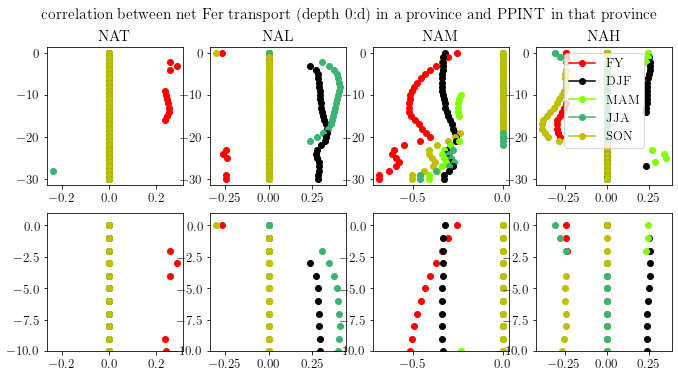

In [30]:
fact = 0.7
fig, axs = plt.subplots(2,4, figsize=(16*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

cols = ['r','k','chartreuse','mediumseagreen','y']
labs = ['F']


for i in range(0,31):
    for s in range(0,5):
        axs[0].plot(tcor_Fer_ppint_NAT[i,s],-i, marker = 'o', color = cols[s])
        axs[4].plot(tcor_Fer_ppint_NAT[i,s],-i, marker = 'o', color = cols[s])

        axs[1].plot(tcor_Fer_ppint_NAL[i,s],-i, marker = 'o', color = cols[s])
        axs[5].plot(tcor_Fer_ppint_NAL[i,s],-i, marker = 'o', color = cols[s])
        
        axs[2].plot(tcor_Fer_ppint_NAM[i,s],-i, marker = 'o', color = cols[s])
        axs[6].plot(tcor_Fer_ppint_NAM[i,s],-i, marker = 'o', color = cols[s])
        
        if i == 0:
            axs[3].plot(tcor_Fer_ppint_NAH[i,s],-i, marker = 'o', color = cols[s], label = tseas[s])
        axs[3].plot(tcor_Fer_ppint_NAH[i,s],-i, marker = 'o', color = cols[s])
        axs[7].plot(tcor_Fer_ppint_NAH[i,s],-i, marker = 'o', color = cols[s])
for i in range(4,8):
    axs[i].set_ylim([-10,1])
    
tits = ['NAT','NAL','NAM','NAH']


for i in range(0,4):
    axs[i].set_title(tits[i])

axs[3].legend()

plt.suptitle('correlation between net Fer transport (depth 0:d) in a province and PPINT in that province')

In [ ]:
tseas = ['FY','DJF','MAM','JJA','SON']

tbd = 73; tprov = 'NAT'
tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'Si', 'RVD0', bd = tbd))
tcor_Si_ppint_NAT = np.zeros([31,5])

for d in range(0,31):

    for s in range(0,5):
        seas = tseas[s]
        
        if seas == 'FY':
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)
        else:
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
            .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)            
        if p > 0.05:
            correlation_coefficient = 0

        tcor_Si_ppint_NAT[d,s] = correlation_coefficient
        
###
tbd = 90; tprov = 'NAL'
tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'Si', 'RVD0', bd = tbd))
tcor_Si_ppint_NAL = np.zeros([31,5])

for d in range(0,31):

    for s in range(0,5):
        seas = tseas[s]
        
        if seas == 'FY':
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)
        else:
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
            .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)            
        if p > 0.05:
            correlation_coefficient = 0

        tcor_Si_ppint_NAL[d,s] = correlation_coefficient
        
        
tbd = 100; tprov = 'NAM'
tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'Si', 'RVD0', bd = tbd))
tcor_Si_ppint_NAM = np.zeros([31,5])

for d in range(0,31):

    for s in range(0,5):
        seas = tseas[s]
        
        if seas == 'FY':
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)
        else:
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
            .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)            
        if p > 0.05:
            correlation_coefficient = 0

        tcor_Si_ppint_NAM[d,s] = correlation_coefficient
        
        
tbd = 109; tprov = 'NAH'
tra = xr.open_mfdataset(make_yearlist(1950, 2020, 'Si', 'RVD0', bd = tbd))
tcor_Si_ppint_NAH = np.zeros([31,5])

for d in range(0,31):

    for s in range(0,5):
        seas = tseas[s]
        
        if seas == 'FY':
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)
        else:
            
            trap = tra.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31'))\
            .sel(time_counter = tra['time_counter.season'] == seas).sel(depthlevel = d).sel(type = 'net').groupby('time_counter.year').mean()

            ann_pp = diadD.regmeanf.sel(varf = 'PPINT').sel(prov = tprov)\
            .sel(time_counter = diadD['time_counter.season'] == seas).groupby('time_counter.year').mean()
            correlation_coefficient, p = pearsonr(trap, ann_pp)            
        if p > 0.05:
            correlation_coefficient = 0

        tcor_Si_ppint_NAH[d,s] = correlation_coefficient
        
        
tseas = ['FY','DJF','MAM','JJA','SON']

fact = 0.7
fig, axs = plt.subplots(2,4, figSize=(16*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

cols = ['r','k','chartreuse','mediumseagreen','y']
labs = ['F']


for i in range(0,31):
    for s in range(0,5):
        axs[0].plot(tcor_Si_ppint_NAT[i,s],-i, marker = 'o', color = cols[s])
        axs[4].plot(tcor_Si_ppint_NAT[i,s],-i, marker = 'o', color = cols[s])

        axs[1].plot(tcor_Si_ppint_NAL[i,s],-i, marker = 'o', color = cols[s])
        axs[5].plot(tcor_Si_ppint_NAL[i,s],-i, marker = 'o', color = cols[s])
        
        axs[2].plot(tcor_Si_ppint_NAM[i,s],-i, marker = 'o', color = cols[s])
        axs[6].plot(tcor_Si_ppint_NAM[i,s],-i, marker = 'o', color = cols[s])
        
        if i == 0:
            axs[3].plot(tcor_Si_ppint_NAH[i,s],-i, marker = 'o', color = cols[s], label = tseas[s])
        axs[3].plot(tcor_Si_ppint_NAH[i,s],-i, marker = 'o', color = cols[s])
        axs[7].plot(tcor_Si_ppint_NAH[i,s],-i, marker = 'o', color = cols[s])
for i in range(4,8):
    axs[i].set_ylim([-10,1])
    
tits = ['NAT','NAL','NAM','NAH']


for i in range(0,4):
    axs[i].set_title(tits[i])

axs[3].legend()

plt.suptitle('correlation between net Si transport (depth 0:d) in a province and PPINT in that province')